<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024



# **Taller 2**

GeoAlpes, una empresa líder en análisis geoespacial, está buscando mejorar sus técnicas de clasificación automática de imágenes satelitales. El objetivo es poder categorizar distintas características geográficas (como bosques, zonas industriales, zonas de cultivos permanentes, zonas residenciales y rios) con alta precisión y rapidez. Para lograrlo, están interesados en explorar las capacidades de los métodos ensemble.

1.  Exploración y Preparación de Datos

    -   Discuta las particularidades de las imágenes satelitales y sugiera técnicas extra de preprocesamiento de ser necesario.

2.  Implementación de Gradient Boosting

    -   Utilice Gradient Boosting como modelo base. Discuta las ventajas y desafíos de este método, y cómo afecta la precisión y robustez del clasificador. Además, compare el desempeño de Gradient Boosting con el modelo Random Forest presentado en la práctica, ¿logra observar mejoras significativas?

3. Implementación de un nuevo metodo Ensemble
    - Elija y presente un método ensemble de su preferencia.Introduzca y discuta el concepto del método elegido y cómo podría ser benéfico para la clasificación de imágenes satelitales.
    - Compare el desempeño de su método elegido con Gradient Boosting y el modelo Random Forest. Discuta las ventajas y desventajas de cada uno.

4.  Optimización y Ajuste

    -   Realice una búsqueda de los mejores hiperparámetros para mejorar el desempeño de cada uno de los modelos implementados (Grid Search).

Datos: [Enlace al sub conjunto del dataset de imágenes satelitales EuroSAT](https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip)


# **Desarrollo taller 2:**

* William Ravelo - 201532093
* Jose Moreno    - 201011998


# Exploración y Preparación de Datos

## Importación de librerias

In [2]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

import cv2
import requests

from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales

from sklearn.ensemble import GradientBoostingClassifier  # Libreria para el modelo de Gradient Boosting
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time

from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros

from sklearn.preprocessing import StandardScaler # Estandarización de datos

from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión
from sklearn.svm import SVC # Máquina de soporte vectorial
from sklearn.ensemble import RandomForestClassifier #Librería para manejo del algoritmo Random Forest

from PIL import Image #Librería para brir, manipular y guardar muchos formatos diferentes de archivos de imágenes.

from skimage import io
from zipfile import ZipFile
from io import BytesIO

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import requests

## Helpers

In [3]:
def show_results(model_name, test, pred):
    # Precisión
    print(f"Precisión de {model_name}:", accuracy_score(y_test, pred))
    
    # Informe de clasificación
    print(f"\nInforme de clasificación de {model_name}:")
    print(classification_report(test, pred))
    
    # Matriz de confusión
    print(f"\nMatriz de confusión de {model_name}:")
    cm_rf = confusion_matrix(test, pred)
    disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
    disp_rf.plot()

In [4]:
def show_sample_images(r_x_test, r_y_test, model_classifier, r_x_test_pca):
    # Seleccionar 10 imágenes aleatorias
    indices = np.random.choice(range(len(r_x_test)), size=10, replace=False)
    
    # Crear una figura con 10 subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    
    # Iterar sobre las 10 imágenes seleccionadas
    for i, index in enumerate(indices):
        # Obtener la imagen y la etiqueta real
        image = r_x_test[index]
        true_label = r_y_test[index]
    
        # Predecir la etiqueta usando RandomForest
        predicted_label_gb = model_classifier.predict([r_x_test_pca[index]])
    
        # Mostrar la imagen
        axes[i // 5, i % 5].imshow(image, cmap='gray')
        # Establecer el título con la etiqueta original, la predicción de Gradient Boosting
        axes[i // 5, i % 5].set_title(f"Original: {true_label}\nGB: {predicted_label_gb[0]}", fontsize=8)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()

## Proceso de carga de imagenes

Normalmente la clasificación de imágenes satelitales en machine learning tienen varias particularidades tales como

- Alta dimensionalidad de los datos ya que pueden tener múltiples bandas como RGB o infrarojo por lo cual se pueden tener varios features, esto hace que sea necesario ejecutar técnicas de reducción de dimensionalidad.

- Gran volumen de datos ya que las imágenes satelitales suelen ser de gran tamaño y cubrir grandes áreas geográficas, esto implica procesar un gran volumen de datos.

- Variabilidad espacial ya que las características de la superficie terrestre pueden variar significativamente dentro de una misma imagen complicando la clasificación.

- Dependencia temporal ya que se depende de las condiciones de iluminación que habia cuando se tomo la imagen al igual que la estacion del año y otros factores temporales.

Para poder resolver estos problemas se aplican algunas tecnicas de pre-procesamiento tales como:

- Reducción de la dimensionalidad haciendo uso de análisis de componentes principales (PCA) para conservar solo aquellos features que más contribuyen a la varianza de los datos, optimizando así el rendimiento de los modelos al eliminar información redundante o poco relevante.

- Diferentes tecnicas de procesamientos de imagenes que ayudan a tener una mejor representación de la imagen para ser procesada por el modelo tales como:
    - Grayscale: Simplifica imágenes a escalas de gris, facilitando la detección de patrones y contornos al reducir la complejidad computacional.

    - HSV (Hue, Saturation, Value): Permite manipular y analizar imágenes basándose en color, mejorando la segmentación y el reconocimiento de objetos al diferenciar más claramente entre tonos.

    - YCrCb: Separa luminancia de crominancia, útil en detección de piel y ajustes de color, mejorando el rendimiento en compresión y procesamiento de vídeo.

    - Binary: Transforma imágenes a blanco y negro, optimizando la segmentación y análisis morfológico al simplificar la estructura visual para un procesamiento más rápido.

    - Edge Detection (e.g., Canny): Identifica bordes con precisión, esencial para la extracción de características y seguimiento de objetos, mejorando la interpretación de formas y estructuras.

    - Multi-Spectral Analysis: Analiza imágenes en múltiples espectros, clave para aplicaciones en teledetección y agricultura, al proporcionar información detallada sobre materiales y cambios en la superficie terrestre.
 
    - Gaussian Filter: Suaviza imágenes reduciendo el ruido y los detalles finos mediante el uso de una función gaussiana. Es fundamental para la preparación de imágenes antes de la detección de bordes, ya que minimiza las posibilidades de detectar falsos bordes.

    - RGB (Red, Green, Blue): El modelo de color primario para imágenes digitales, facilitando la representación y manipulación de imágenes en dispositivos electrónicos, normalmente se usa para tareas de procesamiento de imagen que requieren la preservación del color natural.
 
Para el proceso de imagenes proponemos dos mecanismos a utilizar RGB base y RGB aplicando un filtro gaussiano y de detección de bordes.

### Proceso de cargado usando RGB

In [5]:
def load_image(folder):
    img, y = [], []
    
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels

            # se re-ajustan dimensiones de la imagen para hacer pruebas:
            size=64*2        
            image = cv2.resize(image, (size, size))
            
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

### Proceso de cargado usando RGB + filtro Gaussiano y detección de bordes

In [6]:
def load_image_F(folder):
    img, y = [], []
    
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels

            # se re-ajustan dimensiones de la imagen para hacer pruebas y se usa interpolación:
            size=64*2
            image = cv2.resize(image, (size, size), interpolation=cv2.INTER_CUBIC)

            # Se propone un filtrado de imágenes, lo cual resulta útil para reducir el ruido, mejorar la nitidez.
            # Se usará el filtro Gaussiano, que suaviza la imagen:
            image_f = cv2.GaussianBlur(image, (5, 5), 0)

            # Si se aplica la detección de bordes "Canny", primero pasando a espacio de color de grises:
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Ajustar los umbrales de Canny basándose en las características de la imagen
            sigma = 0.25
            v = np.median(image_gray)
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(min(255, (1.0 + sigma) * v))
            image_b = cv2.Canny(image_gray, lower, upper)

            image_b = cv2.convertScaleAbs(image_b) # se convierte la imagen de bordes a la misma profundidad que la imagen suavizada para poder sumarlas
            
            # Convertir la imagen de bordes (escala de grises) a una imagen de 3 canales para poder sumarla con image_f
            image_b_rgb = cv2.cvtColor(image_b, cv2.COLOR_GRAY2RGB)

            # se agregan o combinan las imágenes utilizando método de fusión:
            alpha = 0.5  # parámetro de ajuste
            imagen_comb = cv2.addWeighted(image_f, alpha, image_b_rgb, 1 - alpha, 0)
            
            img.append(imagen_comb)
            y.append(file)

    return np.array(img), np.array(y)

### Carga de imagenes

A continuación se descarga archivo que contiene las imagenes y se almacena de forma local, luego de eso se procede a cargar las imagenes haciendo uso de los mecanismos mencionados anteriormente.

In [3]:
url = 'https://github.com/ravelinx22/machine-learning/raw/master/Taller_2/EuroSAT3.zip'

response = requests.get(url)
zip_content = response.content
with ZipFile(BytesIO(zip_content)) as zip_file:
    zip_file.extractall("./content/data/EuroSAT")

print("Archivo descomprimido.")

Archivo descomprimido.


In [7]:
path='./content/data/EuroSAT'

X, y = load_image(path)
X_f, y_f = load_image_F(path)

### Partimos el conjunto de datos en un conjunto de entrenamiento (80%) y otro de test (20%), tanto originales como las filtradas

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, random_state=42)


### Tamaño de los datos

In [10]:
X.shape
X_f.shape

(3750, 128, 128, 3)

In [11]:
x_test.shape
x_test_f.shape

(750, 128, 128, 3)

In [12]:
y.shape
y_f.shape

(3750,)

In [13]:
y_test.shape
y_test_f.shape

(750,)

### Distribución de las clases

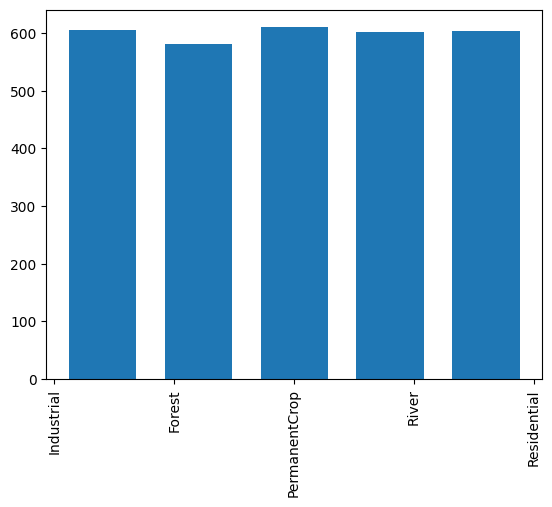

In [14]:
# Observar distribución de clases
plt.hist(y_train, bins=5, rwidth=0.7)
plt.xticks(rotation='vertical')
plt.show()


### Visualización de imagenes de ejemplo

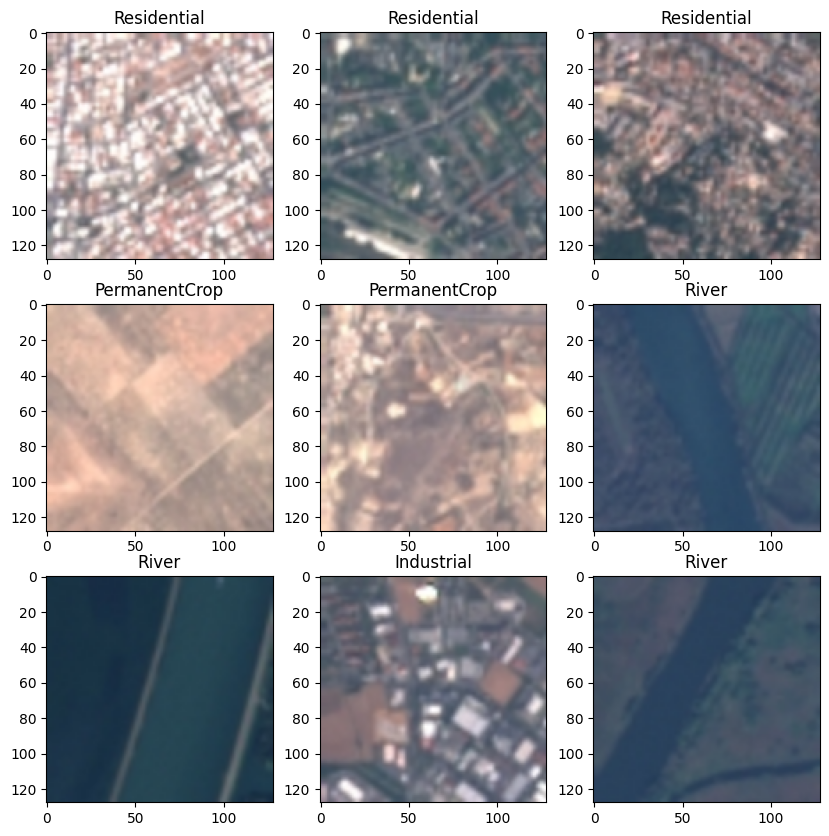

In [15]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train))
    plt.imshow(x_train[rdn])
    plt.title(y_train[rdn])


### Visualización de imagenes de ejemplo con filtrado

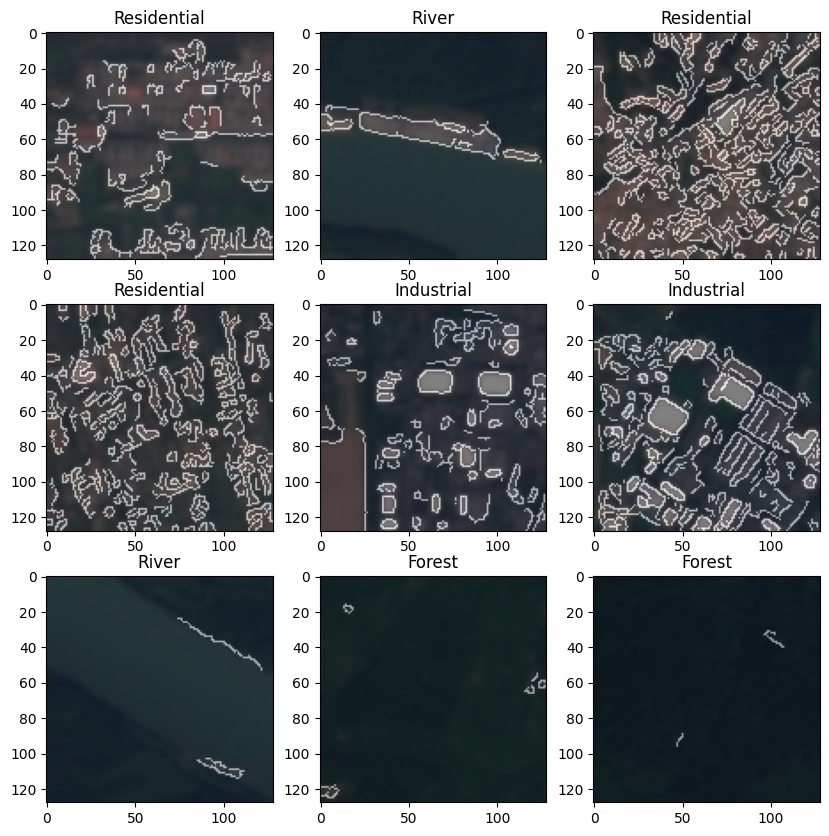

In [16]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train_f))
    plt.imshow(x_train_f[rdn])
    plt.title(y_train_f[rdn])

### Distribución de los labels

In [17]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("Distribución de los labels de entrenamiento: ")
dic_entrenamiento=  dict(zip(unique_train, counts_train))
for clave, valor in dic_entrenamiento.items():
    print(f'{clave}: {valor}')

print("\nDistribución de los labels de test: ")
dic_test= dict(zip(unique_test, counts_test))
for clave, valor in dic_test.items():
    print(f'{clave}: {valor}')

Distribución de los labels de entrenamiento: 
Forest: 581
Industrial: 605
PermanentCrop: 610
Residential: 603
River: 601

Distribución de los labels de test: 
Forest: 169
Industrial: 145
PermanentCrop: 140
Residential: 147
River: 149


## Preparación de los datos para el algoritmo

### Reducción de dimensionalidad y estandarización set de datos RGB base

Usando el set base de imagenes cargado con RGB se hace la conversión de las imagenes a vectores de 1 dimensión y se hace una estandarización de los datos.

In [18]:
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

scaler = StandardScaler().fit(x_train_reshaped)
x_train_standard = scaler.transform(x_train_reshaped)
x_test_standard = scaler.transform(x_test_reshaped)

Luego de la estandarización se procede a hacer PCA para lograr una reducción de la dimensionalidad de los datos intentando conversar un 90% de la varianza.

In [19]:
pca = PCA(0.90).fit(x_train_standard)
x_train_pca = pca.transform(x_train_standard)
x_test_pca = pca.transform(x_test_standard)

Antes de ejecutar PCA contamos con el siguiente número de variables.

In [20]:
x_train_standard.shape

(3000, 49152)

Luego de ejecutar PCA contamos con el siguiente número de variables.

In [21]:
print(f"El número de componente principales que conservan el 90% de la varianza es: {pca.n_components_}")

x_train_pca.shape

El número de componente principales que conservan el 90% de la varianza es: 123


(3000, 123)

Podemos ver que con la muestra inicial de imagenes tendriamos que procesar unas 49.152 variables;
sin embargo gracias a la transformación de PCA, se logra explicar el 90% de la varianza de la muestra con unas 123 variables.

### Reducción de dimensionalidad y estandarización set de datos RGB + Canny + Gaussian filter

Usando el set base de imagenes cargado con RGB y filtrado con Canny y Guassian filter se hace la conversión de las imagenes a vectores de 1 dimensión y se hace una estandarización de los datos.

In [22]:
x_train_reshaped_f = x_train_f.reshape(x_train_f.shape[0], -1)
x_test_reshaped_f = x_test_f.reshape(x_test_f.shape[0], -1)

scaler_f = StandardScaler().fit(x_train_reshaped_f)
x_train_standard_f = scaler_f.transform(x_train_reshaped_f)
x_test_standard_f = scaler_f.transform(x_test_reshaped_f)

Luego de la estandarización se procede a hacer PCA para lograr una reducción de la dimensionalidad de los datos intentando conversar un 90% de la varianza.

In [23]:
pca_f = PCA(0.90).fit(x_train_standard_f)
x_train_pca_f = pca_f.transform(x_train_standard_f)
x_test_pca_f = pca_f.transform(x_test_standard_f)

Antes de ejecutar PCA contamos con el siguiente número de variables.

In [24]:
x_train_standard_f.shape

(3000, 49152)

Luego de ejecutar PCA contamos con el siguiente número de variables.

In [25]:
print(f"PARA MUESTRA IMAGEN FILTRADAS: El número de CP que conservan el 90% de la varianza es: {pca_f.n_components_}")

x_train_pca_f.shape

PARA MUESTRA IMAGEN FILTRADAS: El número de CP que conservan el 90% de la varianza es: 1332


(3000, 1332)

Podemos ver que con la muestra inicial de imagenes tendriamos que procesar unas 49.152 variables;
sin embargo gracias a la transformación de PCA, se logra explicar el 90% de la varianza de la muestra con unas 1332 variables.

# Random Forest

## Creación modelo

Con el proposito de realizar una comparación con otros metodos de predicción se ejecuta primero Random forest.

In [26]:
clasificador_rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)

start = time.time()
clasificador_rf.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento: {end - start}")

Tiempo de entrenamiento: 2.600738048553467


## Predicción datos test

In [27]:
y_pred_rf = clasificador_rf.predict(x_test_pca)

## Resultados

Precisión de Random forest: 0.8186666666666667

Informe de clasificación de Random forest:
               precision    recall  f1-score   support

       Forest       0.98      0.98      0.98       169
   Industrial       0.82      0.95      0.88       145
PermanentCrop       0.74      0.69      0.72       140
  Residential       0.77      0.71      0.74       147
        River       0.75      0.74      0.75       149

     accuracy                           0.82       750
    macro avg       0.81      0.81      0.81       750
 weighted avg       0.82      0.82      0.82       750


Matriz de confusión de Random forest:


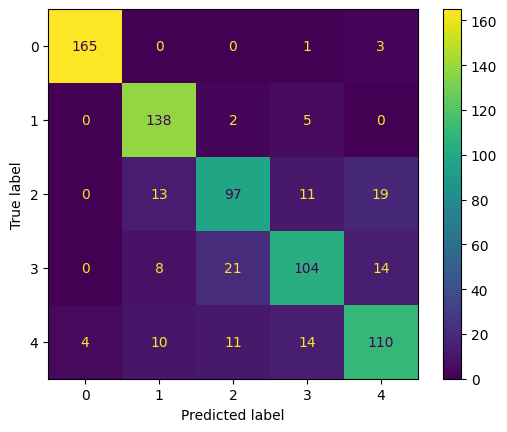

In [28]:
show_results('Random forest', y_test, y_pred_rf)

# Gradient boosting base

El algoritmo de clasificación de  Random Forest es un método de aprendizaje en conjunto (ensemble learning) que opera construyendo múltiples árboles de decisión durante el entrenamiento y produciendo la clase que es la moda de las clasificaciones (para problemas de clasificación) o la media de las predicciones (para problemas de regresión) de los árboles individuales. Random Forest corrige la tendencia de los árboles de decisión a sobreajustarse a su conjunto de entrenamiento, proporcionando un resultado más generalizado y robusto.

El Gradient Boosting es una técnica utilizada para problemas de regresión y clasificación, que produce un modelo de predicción en forma de un ensamble de modelos predictivos más sencillos, generalmente se usan arboles de decisión. 

El algoritmo funciona construyendo de forma iterativa modelos adicionales que corrigen los errores cometidos por las versiones anteriores combinadas. Para efectos de nuestro ejercicio de clasificación de imagenes, el Gradient Boosting aprenderá y mejorará iterativamente a partir de las características que obtiene de las imágenes, ajustándose para minimizar un criterio de pérdida y mejorar la precisión de la clasificación en cada iteración. 

Si se compara el Gradient Boosting con el de Random Forest, se pueden plantear pros y contras: 

**Pros de Gradient Boosting** 
- Tiene mejor capacidad predictiva por su enfoque iterativo y adaptativo para minimizar errores
- Es flexible con respecto a la función de pérdida y, por lo tanto, puede ser más afinado para problemas específicos. 

**Contras de Gradient Boosting** 
- Puede ser más susceptible al sobreajuste, especialmente con datos ruidosos o en situaciones con una cantidad limitada de datos
- Puede ser más lento para entrenar que el Random Forest debido a su naturaleza iterativa y secuencial, no paralelizable, lo cual ante un conjunto con muchas imagenes puede tomar demasiado tiempo. Por otro lado, Random Forest es más fácil de paralelizar y puede ser más robusto al sobreajuste.



### Creación de modelo con muestra de datos RGB

Se realiza un primer acercamiento usando Gradient Boosting con 50 estimadores y se presenta la precisión al realizar una predicción con los datos test.

In [29]:
clasificador_gb = GradientBoostingClassifier(n_estimators=50, random_state=0)

start = time.time() # 20 seconds aprox
clasificador_gb.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento con Gradient Boosting: {end - start}")

y_pred_gb = clasificador_gb.predict(x_test_pca)

print("Precisión de Gradient Boosting:", accuracy_score(y_test, y_pred_gb),', con un número de iteraciones de 50')

Tiempo de entrenamiento con Gradient Boosting: 21.269814014434814
Precisión de Gradient Boosting: 0.832 , con un número de iteraciones de 50


Se ejecuta un segundo acercamiento usando Gradient Boosting con 100 estimadores y se presenta la precisión al realizar una predicción con los datos test.

In [30]:
clasificador_gb = GradientBoostingClassifier(n_estimators=100, random_state=0)

start = time.time() # 40 seconds aprox
clasificador_gb.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento con Gradient Boosting: {end - start}")

y_pred_gb = clasificador_gb.predict(x_test_pca)

print("Precisión de Gradient Boosting:", accuracy_score(y_test, y_pred_gb),', con un número de iteraciones de 100')

Tiempo de entrenamiento con Gradient Boosting: 42.27593374252319
Precisión de Gradient Boosting: 0.8453333333333334 , con un número de iteraciones de 100


Podemos ver que con 100 estimadores contamos con mayor precisión al probarlo con los datos test

Precisión de Gradient Boosting con 100 iteraciones: 0.8453333333333334

Informe de clasificación de Gradient Boosting con 100 iteraciones:
               precision    recall  f1-score   support

       Forest       0.93      0.96      0.94       169
   Industrial       0.90      0.91      0.90       145
PermanentCrop       0.78      0.79      0.79       140
  Residential       0.79      0.77      0.78       147
        River       0.81      0.77      0.79       149

     accuracy                           0.85       750
    macro avg       0.84      0.84      0.84       750
 weighted avg       0.84      0.85      0.84       750


Matriz de confusión de Gradient Boosting con 100 iteraciones:


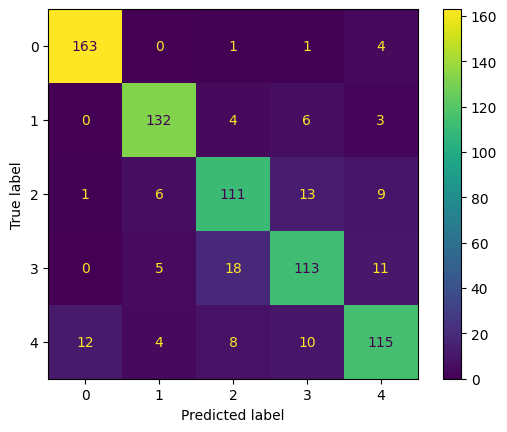

In [31]:
show_results('Gradient Boosting con 100 iteraciones', y_test, y_pred_gb)

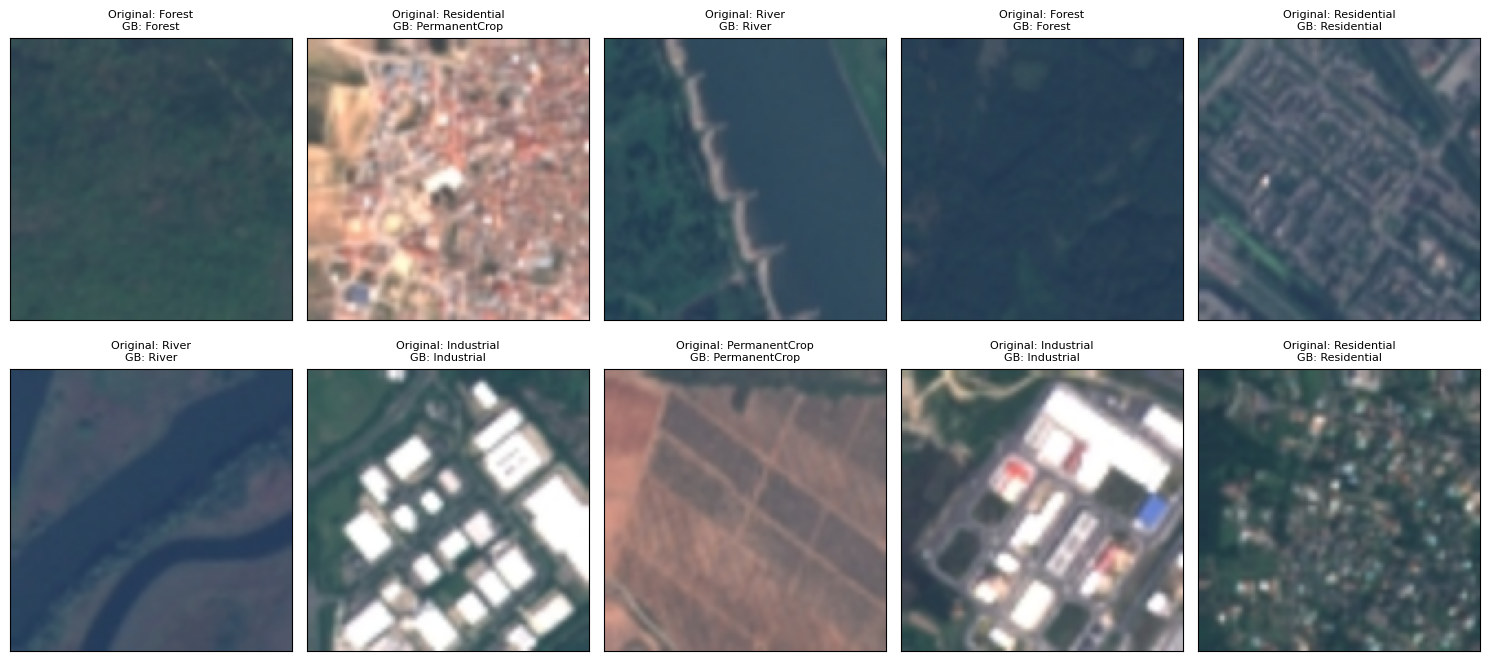

In [32]:
show_sample_images(x_test, y_test, clasificador_gb, x_test_pca)

### Creación de modelo con muestra de datos RGB + Canny + Gaussian filter

In [33]:
clasificador_gb_f = GradientBoostingClassifier(n_estimators=100, random_state=0)

start = time.time() # 539 seconds Aprox
clasificador_gb_f.fit(x_train_pca_f, y_train_f)
end = time.time()

print(f"Tiempo de entrenamiento con Gradient Boosting: {end - start}")

Tiempo de entrenamiento con Gradient Boosting: 452.06264305114746


In [34]:
y_pred_gb_f = clasificador_gb_f.predict(x_test_pca_f)

print("Precisión de Gradient Boosting:", accuracy_score(y_test_f, y_pred_gb_f),', con un número de iteraciones de 100')

Precisión de Gradient Boosting: 0.812 , con un número de iteraciones de 100


Precisión de Gradient Boosting con 100 iteraciones: 0.812

Informe de clasificación de Gradient Boosting con 100 iteraciones:
               precision    recall  f1-score   support

       Forest       0.94      0.98      0.96       169
   Industrial       0.79      0.87      0.83       145
PermanentCrop       0.79      0.80      0.79       140
  Residential       0.83      0.56      0.67       147
        River       0.72      0.83      0.77       149

     accuracy                           0.81       750
    macro avg       0.81      0.81      0.80       750
 weighted avg       0.82      0.81      0.81       750


Matriz de confusión de Gradient Boosting con 100 iteraciones:


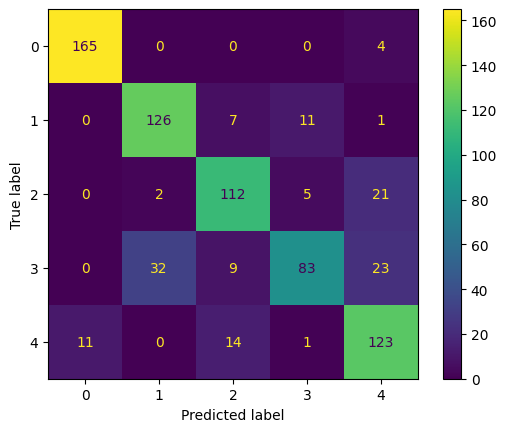

In [35]:
show_results('Gradient Boosting con 100 iteraciones', y_test_f, y_pred_gb_f)

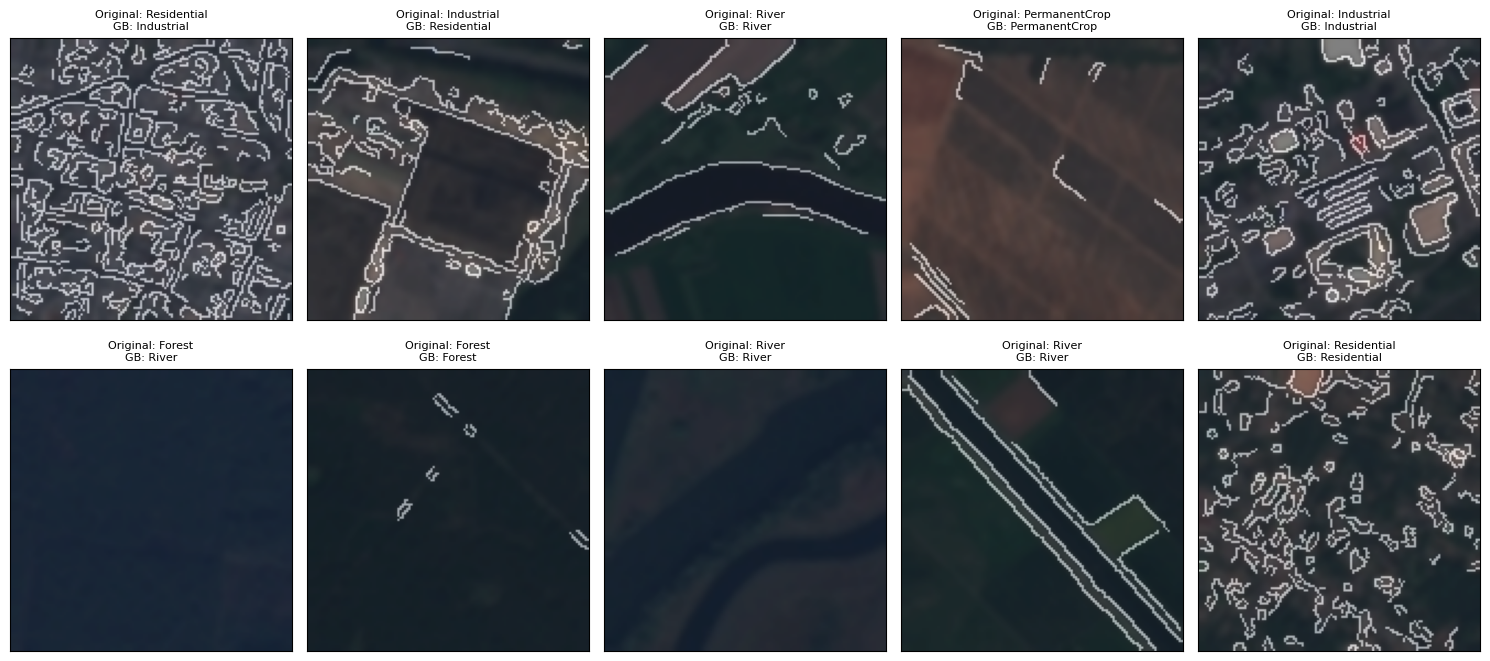

In [36]:
show_sample_images(x_test_f, y_test_f, clasificador_gb_f, x_test_pca_f)

## Resultados del ejercicio comparativo Gradient Boosting y Random forest

En este punto, se compararán entonces 3 tipos de modelos evaluados:

1. Modelo de RandomForest
2. Modelo de Gradient Boosting, con dataset preprocesado de forma básica Reescalamiento (RGB)
3. Modelo de GRadient Boosting, con dataset preprocesado con Reescalamiento+Suavizamiento+Detección Bordes (RGB + Gaussian filter + Canny)

Los resultados del algoritmo de Gradient Boosting con procesamiento básico (RGB) fueron mejores frente a los demás modelos evaluados. Se presenta los resultados ordenas de mayor precisión a menor. 

1. Modelo de Gradient Boosting (RGB+Canny+Gaussian filter) Precisión básico 85%
2. Modelo de RandomForest - Precisión 81,6% 
3. Modelo de Gradient Boosting (RGB) Precisión 81,2%

Con estos resultados podemos ver que la precisión de Random Forest y Gradient Boosting son bastante cercanas entre sí y reflejan cómo ambos métodos, sin preprocesamiento adicional de las imágenes, ofrecen resultados comparables en términos de precisión. Random Forest demostró ser ligeramente superior, lo que podría atribuirse a su robustez y capacidad para manejar la variabilidad y complejidad de los datos de imágenes.
Sin embargo, la aplicación de Gradient Boosting a imágenes que fueron procesadas previamente con filtros Canny y Gaussian Filter tuvo una diferencia significativa, elevando la precisión al 85%. Este aumento puede darse debido a que los filtros mejoran la calidad de los datos de entrada para el modelo de Gradient Boosting. El Gaussian Filter suaviza la imagen, reduciendo el ruido y destacando las características importantes, mientras que el filtro Canny enfatiza los bordes, mejorando la detección de características críticas en las imágenes. Estas mejoras en la calidad de los datos permiten que el modelo Gradient Boosting se enfoque en los aspectos más relevantes de las imágenes, facilitando una clasificación más precisa.

# Stacked generalization modelo base

Hay diferentes tecnicas ensemble que permiten combinar modelos para aumentar la precisión tales como Histogram Based Gradient Boosting, Voting Classifier, Voting Regressor o Stacked generalization, en este caso evaluaremos el desempeño del modelo Stacked Generalization.

El modelo de Stacked Generalization es una técnica de aprendizaje en conjunto que combina múltiples modelos de clasificación o regresión para producir una predicción más precisa que la que cualquiera de los modelos individuales podría hacer por sí solo. Funciona entrenando un modelo meta (o de nivel superior) para combinar las predicciones de varios modelos base entrenados previamente, utilizando sus salidas como entradas para este modelo meta. La idea es aprovechar las fortalezas y compensar las debilidades de los modelos base, mejorando así la precisión de las predicciones.

**Pros de Stacked generalization:**

- Mejora la capacidad predictiva al combinar múltiples modelos, aprovechando sus fortalezas individuales.
- Es versátil y puede aplicarse a cualquier tipo de problema de modelado, ya sea clasificación, regresión o incluso tareas de series temporales.

**Contras de Stacked generalization:**

- Su complejidad y el coste computacional son más altos en comparación con usar un único modelo, debido al entrenamiento de múltiples modelos base y un modelo meta.
- Requiere cuidado en la selección y entrenamiento de los modelos base para evitar el sobreajuste y garantizar que las mejoras sean significativas.

### Creación de modelo con muestra de datos RGB

Se crea modelo para modelo de datos RGB haciendo uso de los modelos base (Random forest, SVC, y decision tree classifier) y se usa como meta modelo gradient boosting classifier

In [37]:
modelos_base = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]

meta_modelo_gbN = GradientBoostingClassifier(n_estimators=100, random_state=42)

clasificador_stacking_gbN = StackingClassifier(estimators=modelos_base, final_estimator=meta_modelo_gbN, cv=5)

start = time.time() # 20 seconds aprox
clasificador_stacking_gbN.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento con Stacked Generalization (Gradient Boosting): {end - start}")

Tiempo de entrenamiento con Stacked Generalization (Gradient Boosting): 19.36607599258423


Se realiza predicción sobre los datos test

In [38]:
y_pred_stacking_gbN = clasificador_stacking_gbN.predict(x_test_pca)

print("Precisión de Stacked Generalization (Gradient Boosting):", accuracy_score(y_test, y_pred_stacking_gbN))

Precisión de Stacked Generalization (Gradient Boosting): 0.884


Se puede ver que se logra una precisión del 88.4% la mas alta hasta ahora

Precisión de Stacked Generalization: 0.884

Informe de clasificación de Stacked Generalization:
               precision    recall  f1-score   support

       Forest       0.96      0.98      0.97       169
   Industrial       0.92      0.94      0.93       145
PermanentCrop       0.83      0.85      0.84       140
  Residential       0.81      0.80      0.80       147
        River       0.87      0.84      0.86       149

     accuracy                           0.88       750
    macro avg       0.88      0.88      0.88       750
 weighted avg       0.88      0.88      0.88       750


Matriz de confusión de Stacked Generalization:


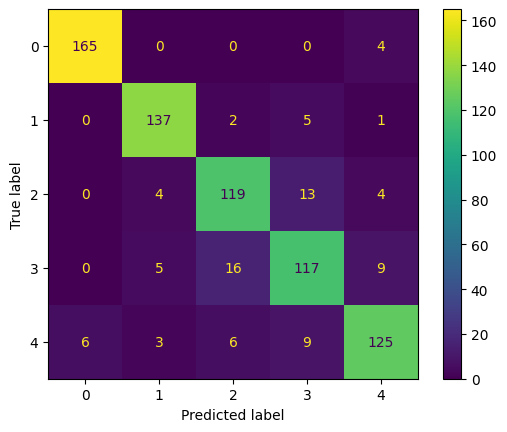

In [39]:
show_results('Stacked Generalization', y_test, y_pred_stacking_gbN)

### Creación de modelo con muestra de datos RGB + Canny + Gaussian filter

Se crea modelo para modelo de datos RGB + Canny + Gaussian Filter haciendo uso de los modelos base (Random forest, SVC, y decision tree classifier) y se usa como meta modelo gradient boosting classifier

In [40]:
meta_modelo_gbN_f = GradientBoostingClassifier(n_estimators=100, random_state=42)
clasificador_stacking_gbN_f = StackingClassifier(estimators=modelos_base, final_estimator=meta_modelo_gbN_f, cv=5)

start = time.time() # 110 seconds aprox
clasificador_stacking_gbN_f.fit(x_train_pca_f, y_train_f)
end = time.time()
print(f"Tiempo de entrenamiento con Stacked Generalization (Gradient Boosting) - Imagenes Filtradas: {end - start}")

Tiempo de entrenamiento con Stacked Generalization (Gradient Boosting) - Imagenes Filtradas: 130.36314129829407


Se realiza predicción sobre los datos test

In [41]:
y_pred_stacking_gbN_f = clasificador_stacking_gbN_f.predict(x_test_pca_f)

print("Precisión de Stacked Generalization - Imagenes Filtradas (Gradient Boosting):", accuracy_score(y_test_f, y_pred_stacking_gbN_f))

Precisión de Stacked Generalization - Imagenes Filtradas (Gradient Boosting): 0.64


Se puede ver que hubo una disminución significativa en la predicción llegando al 64%

Precisión de Stacked Generalization: 0.64

Informe de clasificación de Stacked Generalization:
               precision    recall  f1-score   support

       Forest       0.96      0.99      0.97       169
   Industrial       0.89      0.32      0.47       145
PermanentCrop       0.37      0.86      0.52       140
  Residential       0.66      0.16      0.25       147
        River       0.74      0.82      0.78       149

     accuracy                           0.64       750
    macro avg       0.72      0.63      0.60       750
 weighted avg       0.73      0.64      0.61       750


Matriz de confusión de Stacked Generalization:


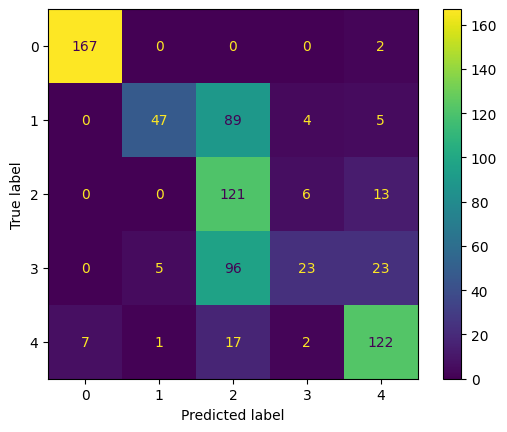

In [42]:
show_results('Stacked Generalization', y_test_f, y_pred_stacking_gbN_f)

En el contexto del reconocimiento de imágenes satelitales, los resultados de precisión para los tres métodos fueron: Random Forest con 81.6%, Gradient Boosting con 81.2% y Gradient Boosting aplicado a imágenes procesadas con filtros Canny y Gaussian mejorando a 85%. Sin embargo, al implementar Stacked Generalization en datos sin filtrar, la precisión aumentó significativamente a 88%, mientras que la aplicación de los mismos filtros en este último contexto redujo la precisión a 63%.

Random Forest demostró ser robusto ofreciendo una solución sólida con una implementación relativamente sencilla y menos susceptible al sobreajuste dado que no hubo mucha variación entre la precision en los datos test y los de entrenamiento.

Gradient Boosting mostró un rendimiento comparable al de Random Forest en su forma básica, pero destacó especialmente al aplicarse sobre datos preprocesados con filtros Canny y Gaussian, lo que sugiere una sensibilidad favorable a mejoras en la calidad de entrada de datos que resaltan características relevantes.

Stacked Generalization sobresalió al alcanzar la mayor precisión (88%) en datos sin filtrar, evidenciando su capacidad superior para integrar y maximizar la diversidad de predicciones de múltiples modelos base. Sin embargo, su rendimiento disminuyó drásticamente con el preprocesamiento de imágenes, lo que indica una posible dependencia crítica de la integridad de los datos originales y una menor adaptabilidad a la alteración de las características esenciales mediante filtros, tambien puede darse que como se usan diferentes modelos, alguno de estos modelos puede que sea sensible a los filtros utilizados y de resultados no favorables afectando el resultado global del modelo.

# Optimización y Ajuste de Modelos - Busqueda de Hiperparámetros

Para la optimización y ajuste de modelos consideraremos los siguientes modelos para la busqueda de sus respectivos hiperparámetros:

- Gradient Boosting para MUESTRA con PREPROCESAMIENTO BASICO (RGB)
- Método Ensemble con Stacked generalization con PREPROCESAMIENTO BASICO (RGB)

## Optimización de Hiperparámetros para Gradient Boosting usando muestra RGB

Para hacer la busqueda de hiperparametros variaremos los valores:

- n_estimators: Número de iteracines
- learning rate: Tasa de aprendizaje
- max_depth: Profundidad maxima de arboles

Asi mismo se usa la opción n_jobs igual a -1 para se utilizar todas las CPUs disponibles y asi paralelizar los trabajos de optimización.

In [43]:
pipeline = Pipeline([
    ('clf', GradientBoostingClassifier(random_state=0))
])

param_grid = {
    'clf__n_estimators': [50, 100, 150],
    'clf__learning_rate': [1.0], 
    'clf__max_depth': [2, 3, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

A continuación se hace la ejecución de GridSearch

In [44]:
start = time.time() # 221 seconds aprox
grid_search.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento con GridSearchCV: {end - start}")

print("Mejores parámetros: ", grid_search.best_params_)

print("Mejor puntuación de GridSearchCV: ", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tiempo de entrenamiento con GridSearchCV: 217.51264786720276
Mejores parámetros:  {'clf__learning_rate': 1.0, 'clf__max_depth': 3, 'clf__n_estimators': 150}
Mejor puntuación de GridSearchCV:  0.8386666666666667


Se utiliza los datos test para predecir su resultado y hallar la precisión del modelo.

In [45]:
y_pred_optimized = grid_search.predict(x_test_pca)
print("Precisión del Gradient Boosting optimizado:", accuracy_score(y_test, y_pred_optimized))

Precisión del Gradient Boosting optimizado: 0.86


Podemos ver que llegamos a una precisión del 86% que es mayor a la inicial sin optimización del 84.5%

Precisión de Gradient Boosting optimizado : 0.86

Informe de clasificación de Gradient Boosting optimizado :
               precision    recall  f1-score   support

       Forest       0.96      0.97      0.96       169
   Industrial       0.91      0.91      0.91       145
PermanentCrop       0.81      0.74      0.77       140
  Residential       0.78      0.84      0.81       147
        River       0.83      0.81      0.82       149

     accuracy                           0.86       750
    macro avg       0.86      0.86      0.86       750
 weighted avg       0.86      0.86      0.86       750


Matriz de confusión de Gradient Boosting optimizado :


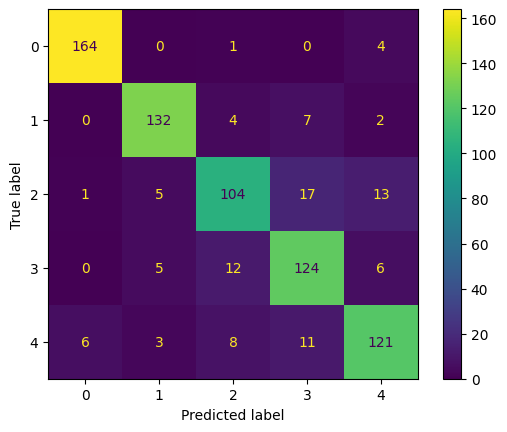

In [46]:
show_results('Gradient Boosting optimizado ', y_test, y_pred_optimized)

## Optimización de Hiperparámetros para Stacked Generalization usando muestra RGB

Para el stack generalization usaremos los siguientes modelos base
- Random forest
- SVC
- Decision Tree Classifier

De igual forma usaremos como metamodelo el Gradien Boosting, siguiente a eso haremos la busqueda de hiperparametros variando los valores:

- n_estimators: Número de iteracines
- C: Parametro de complejidad SVC
- dt_max_depth: Profundidad maxima de arboles
- learning rate: Tasa de aprendizaje

Asi mismo se usa la opción n_jobs igual a -1 para se utilizar todas las CPUs disponibles y asi paralelizar los trabajos de optimización.

In [47]:
modelos_base = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]

meta_modelo_gb = GradientBoostingClassifier(random_state=42)

clasificador_stacking = StackingClassifier(estimators=modelos_base, final_estimator=meta_modelo_gb, cv=5)

param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'svc__C': [0.1, 1],
    'dt__max_depth': [None, 10],
    'final_estimator__n_estimators': [50, 100, 150],
    'final_estimator__learning_rate': [1.0]
}

grid_search = GridSearchCV(estimator=clasificador_stacking, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

A continuación se hace la ejecución de GridSearch

In [48]:
start = time.time() # 194 seconds aprox
grid_search.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento con GridSearchCV: {end - start}")

print("Mejores parámetros: ", grid_search.best_params_)

print("Mejor puntuación de GridSearchCV: ", grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Tiempo de entrenamiento con GridSearchCV: 191.41833591461182
Mejores parámetros:  {'dt__max_depth': None, 'final_estimator__learning_rate': 1.0, 'final_estimator__n_estimators': 150, 'rf__n_estimators': 150, 'svc__C': 1}
Mejor puntuación de GridSearchCV:  0.8409999999999999


Se utiliza los datos test para predecir su resultado y hallar la precisión del modelo.

In [49]:
y_pred_optimized = grid_search.predict(x_test_pca)

print("Precisión del modelo optimizado:", accuracy_score(y_test, y_pred_optimized))

Precisión del modelo optimizado: 0.8573333333333333


Podemos ver que llegamos a una precisión del 86% que es mayor a la inicial sin optimización del 85.7%

Precisión de Gradient Boosting optimizado : 0.8573333333333333

Informe de clasificación de Gradient Boosting optimizado :
               precision    recall  f1-score   support

       Forest       0.95      0.98      0.97       169
   Industrial       0.89      0.89      0.89       145
PermanentCrop       0.82      0.82      0.82       140
  Residential       0.75      0.79      0.77       147
        River       0.87      0.79      0.82       149

     accuracy                           0.86       750
    macro avg       0.85      0.85      0.85       750
 weighted avg       0.86      0.86      0.86       750


Matriz de confusión de Gradient Boosting optimizado :


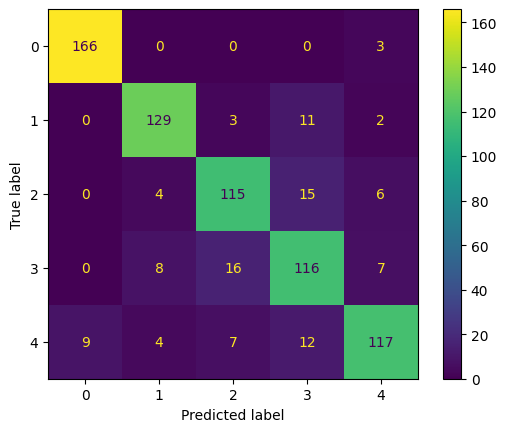

In [50]:
show_results('Gradient Boosting optimizado ', y_test, y_pred_optimized)

Finalmente podemos ver que aunque se hace una optimización de hiperparametros no hubo mucha diferencia entre las precisiones antes de la optimización, esto supone que los valores de hiperparametros probados no tienen mayor afectación y puede que sea necesario incluir mas valores, sin embargo, esto requiere un mayor poder de computo y tiempo de ejecución.